In [1342]:


import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [1343]:
# Carrega o dataset como dataframe
df = pd.read_csv('dataset/video_games_2016.csv')

In [1344]:
# Remove outliers
Q1 = df['Global_Sales'].quantile(0.00)
Q3 = df['Global_Sales'].quantile(0.98)

df = df[(df['Global_Sales'] >= Q1 ) & (df['Global_Sales'] <= Q3 )]

In [1345]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

df['Greatest'] = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)

In [1346]:
fill_0 = [
    "Critic_Score",
    "Critic_Count",
    "User_Score",
    "User_Count",
]

fill_mean = [
    'Year_of_Release',
    'Global_Sales'
]

for c in fill_0 :
    df[c] = df[c].fillna(0)

for c in fill_mean :
    df[c] = df[c].fillna(df[c].mean())


In [1347]:
df["Platform_Code"] = df[ "Platform" ].astype("category").cat.codes

In [1348]:
fdf = df.copy()

def reduce_platforms( l ):
    s = 0;
    for i in l:
        s |= 1 << i+1
    return s

grouped = fdf.groupby( "Name" )

a = grouped.agg(
    Genre=("Genre", "first"),
    Developer=("Developer", "first"),
    Greatest=("Greatest", "first"),
    Publisher=("Publisher", "first"),
    Year_of_Release=("Year_of_Release", "first"),
    Rating=("Rating", "first"),

    Count_Platforms=("Name", "count"),

    Platform_Codes=("Platform_Code", reduce_platforms),

    Global_Sales=("Global_Sales", "sum"),
    NA_Sales=("NA_Sales", "sum"),
    EU_Sales=("EU_Sales", "sum"),
    JP_Sales=("JP_Sales", "sum"),
    Other_Sales=("Other_Sales", "sum"),

    True_Score=("Critic_Score", "max"), 
    User_Score=("User_Score", "max"), 

    User_Count=("User_Count", "sum"), 
    Critic_Count=("Critic_Count", "sum"), 
    # True_Score=("Critic_Score", lambda x: (x * grouped["Critic_Count"].get_group(x.name)).sum() / grouped["Critic_Count"].get_group(x.name).sum()), 
    # Critic_Score=("Critic_Score", lambda x: x)
).reset_index()

a.sort_values("Count_Platforms", ascending=False).head(4)

KeyboardInterrupt: 

/tmp/ipykernel_1432996/1045375929.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


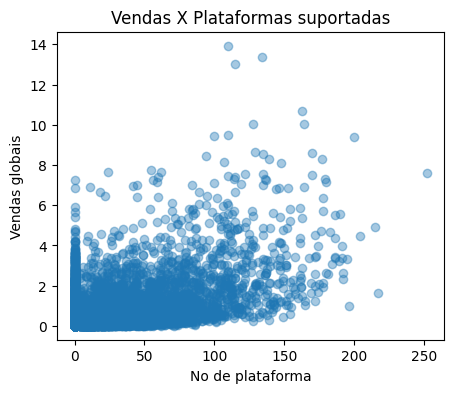

In [ ]:

fdf = a
# fdf = fdf.groupby("Count_Platforms")["Global_Sales"].mean().reset_index()

plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['Critic_Count'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('No de plataforma')

plt.title('Vendas X Plataformas suportadas')

plt.show()

/tmp/ipykernel_1432996/2260312164.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


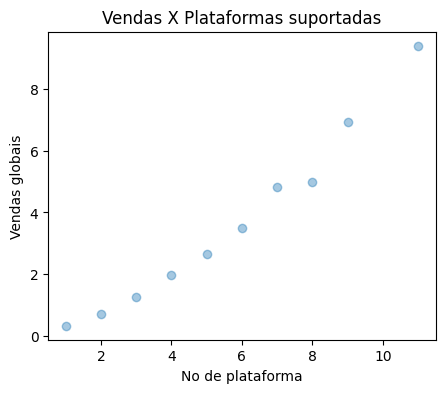

In [ ]:
fdf = a
fdf = fdf.groupby("Count_Platforms")["Global_Sales"].mean().reset_index()


plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['Count_Platforms'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('No de plataforma')

plt.title('Vendas X Plataformas suportadas')

plt.show()

/tmp/ipykernel_1432996/3098255162.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


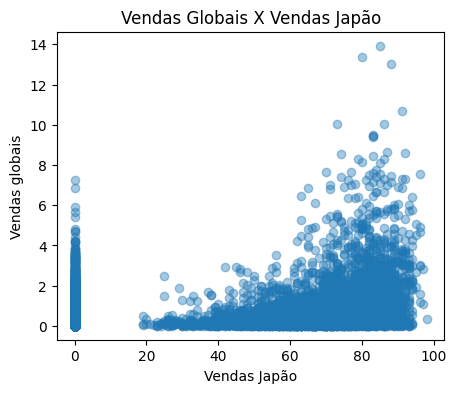

In [ ]:

fdf = a
fdf.dropna()

plt.figure(figsize=(5, 4))
plt.scatter( 
  fdf['True_Score'],
  fdf['Global_Sales'],

  cmap='viridis',
  alpha=.4
)

plt.ylabel('Vendas globais')
plt.xlabel('Vendas Japão')

plt.title('Vendas Globais X Vendas Japão')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
target = 'Global_Sales'

numeric_features = [ 
    "Count_Platforms",
    'True_Score',
    'Critic_Count',
]  

categorical_features = [
    'Genre',
    'Year_of_Release',
    'Publisher'
]  

fdf = a.copy()
fdf = fdf[ fdf[ "True_Score" ] > 0 ]
fdf[categorical_features] = fdf[categorical_features].fillna('NA')  

X = fdf[numeric_features + categorical_features]
y = fdf[ target ]  

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=2, include_bias=False ) , numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])


In [ ]:
model_pipeline.fit(X_train, y_train)
y_pred= model_pipeline.predict(X_test)

/home/wolke/Documents/datascience/topicos-4/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 0.6835014119163374
R-squared: 0.5415144918267829


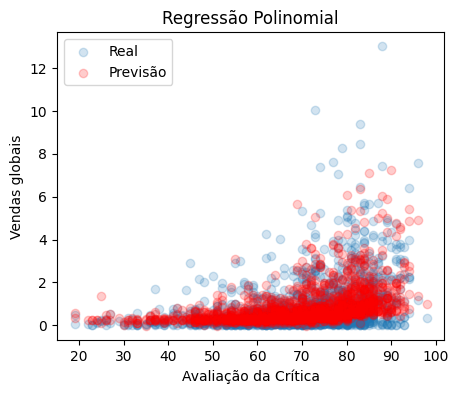

In [ ]:
plt.figure(figsize=(5, 4))
plt.scatter(X_test['True_Score'], y_test, alpha=0.2, label='Real')

plt.scatter(X_test["True_Score"], y_pred, color='red', alpha=0.2, label='Previsão')

plt.xlabel('Avaliação da Crítica')
plt.ylabel('Vendas globais')
plt.title('Regressão Polinomial')
plt.legend()
plt.show()

/home/wolke/Documents/datascience/topicos-4/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


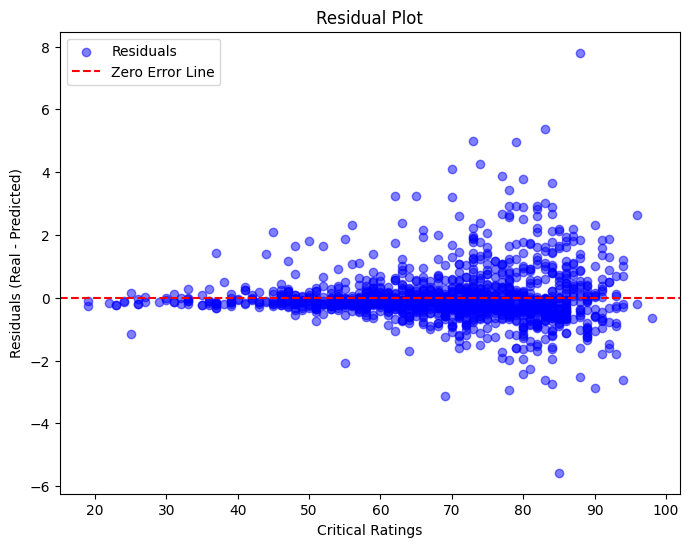

In [ ]:
y_pred = model_pipeline.predict(X_test)

residuals = y_test - y_pred

x_axis_values = X_test['True_Score'] 

plt.figure(figsize=(8, 6))
plt.scatter(x_axis_values, residuals, alpha=0.5, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

plt.title('Residual Plot')
plt.xlabel('Critical Ratings')
plt.ylabel('Residuals (Real - Predicted)')
plt.legend()
plt.show()
